Step 1: Load Data

In [4]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/Large_SaaS_Churn_Dummy_Data__100K_rows_.csv')

# Quick check
print(data.head())
print(data.info())


   customer_id  monthly_usage_hours  num_support_tickets  num_logins  \
0            1            44.967142                    2          54   
1            2            38.617357                    1          23   
2            3            46.476885                    2          22   
3            4            55.230299                    1          82   
4            5            37.658466                    4          91   

  plan_type  tenure_months  customer_satisfaction_score  num_features_used  \
0       Pro              7                         2.15                 17   
1       Pro             30                         1.13                 17   
2     Basic             19                         3.26                  1   
3     Basic             23                         4.02                  5   
4     Basic              5                         4.55                 14   

   avg_ticket_resolution_time  has_account_manager  churned  
0                   23.439844       

Step 2: Exploratory Data Analysis (EDA)

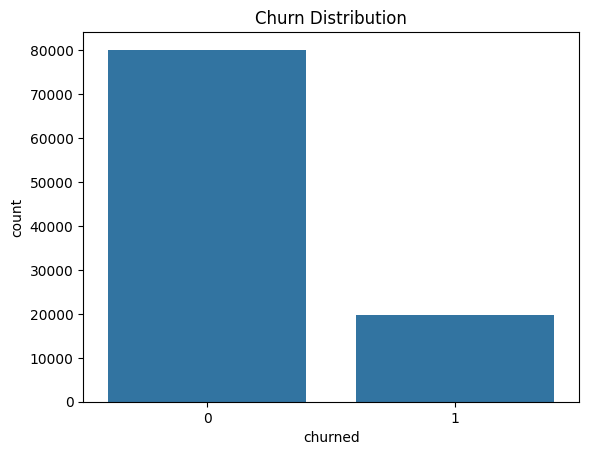

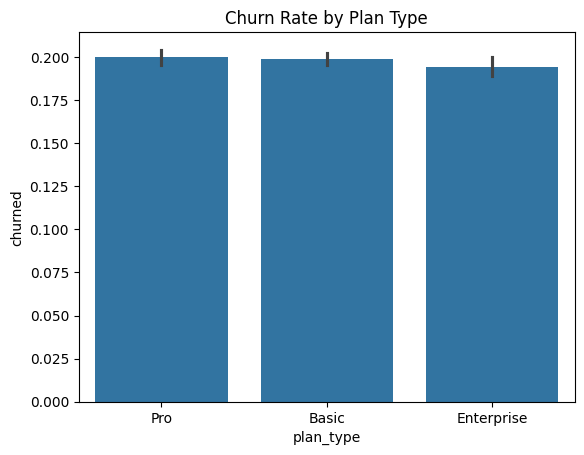

ValueError: could not convert string to float: 'Pro'

<Figure size 1000x800 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn distribution
sns.countplot(x='churned', data=data)
plt.title('Churn Distribution')
plt.show()

# Churn rate by plan type
sns.barplot(x='plan_type', y='churned', data=data)
plt.title('Churn Rate by Plan Type')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Step 3: Data Preprocessing

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Encode categorical variables
data_encoded = pd.get_dummies(data, columns=['plan_type'], drop_first=True)

# Features and target
X = data_encoded.drop(['customer_id', 'churned'], axis=1)
y = data_encoded['churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Step 4: Build Machine Learning Model

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')


[[16002     0]
 [ 3994     4]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     16002
           1       1.00      0.00      0.00      3998

    accuracy                           0.80     20000
   macro avg       0.90      0.50      0.45     20000
weighted avg       0.84      0.80      0.71     20000

ROC-AUC Score: 0.5005002501250625


Step 5: Identify Top Churn Drivers (Feature Importance)

                       feature  importance
0          monthly_usage_hours    0.186278
6   avg_ticket_resolution_time    0.186222
4  customer_satisfaction_score    0.167251
2                   num_logins    0.141057
3                tenure_months    0.115339
5            num_features_used    0.098458
1          num_support_tickets    0.055592
7          has_account_manager    0.018252
9                plan_type_Pro    0.017617
8         plan_type_Enterprise    0.013934


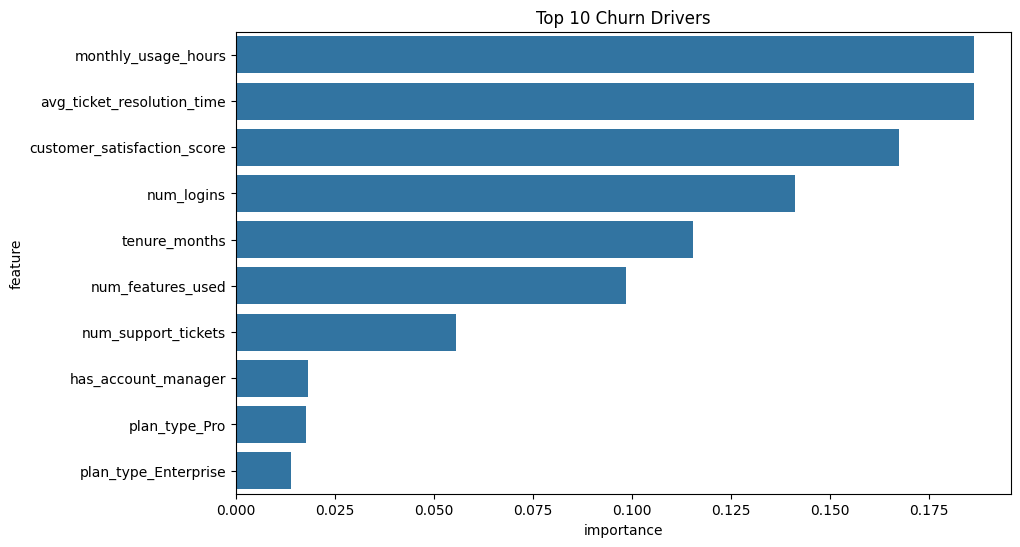

In [8]:
# Feature importances
importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Churn Drivers')
plt.show()


Step 6: Create Retention Insights for Tableau

In [9]:
# Aggregate churn by plan type and account manager
retention_summary = data.groupby(['plan_type', 'has_account_manager'])['churned'].mean().reset_index()
retention_summary.rename(columns={'churned': 'churn_rate'}, inplace=True)

print(retention_summary)

# Save for Tableau
retention_summary.to_csv('retention_summary.csv', index=False)


    plan_type  has_account_manager  churn_rate
0       Basic                    0    0.198930
1       Basic                    1    0.199601
2  Enterprise                    0    0.196249
3  Enterprise                    1    0.190105
4         Pro                    0    0.200344
5         Pro                    1    0.199440


Step 7: Save Predictions for CRM Integration

In [10]:
# Add predictions back to customer data
data['churn_probability'] = model.predict_proba(scaler.transform(X))[:,1]

# Flag high-risk customers (e.g., probability > 0.7)
data['high_risk_flag'] = (data['churn_probability'] > 0.7).astype(int)

# Export to CSV for CRM integration
data[['customer_id', 'churn_probability', 'high_risk_flag']].to_csv('churn_risk_flags.csv', index=False)
